In [11]:
import os
# import yaml
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Show all rows from pandas
# pd.set_option('display.max_rows', None)
import xlwings as xw
%matplotlib inline
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual

# PARAMETRES ET CONSTANTES

In [12]:
# Open the existing workbook
workbook = xw.Book('TEMPLATE_DDC.xlsx')
# workbook = xw.Book()

# Avec template excel

In [13]:
config_sheet = workbook.sheets['config']
last_row = config_sheet.range('B1').end('down').row
last_col = config_sheet.range('A1').end('right').column
nb_cas = last_col-2
print(f'last_row={last_row}, last_col={last_col}, nb_cas={nb_cas}')
config = {}

for col in range(3, last_col+1):
    config[int(config_sheet.range((1,col)).value)] = {}
    for row in range(2, last_row+1):
        config[int(config_sheet.range((1,col)).value)][config_sheet.range((row,2)).value] = config_sheet.range((row,col)).value
    # On convertit les variables dans le bon format
    if config[int(config_sheet.range((1,col)).value)]['composantes']!=None:
        config[int(config_sheet.range((1,col)).value)]['composantes'] = config[int(config_sheet.range((1,col)).value)]['composantes'].split(',')
    if config[int(config_sheet.range((1,col)).value)]['groupe']!=None:
        config[int(config_sheet.range((1,col)).value)]['groupe'] = int(config[int(config_sheet.range((1,col)).value)]['groupe'])
    if config[int(config_sheet.range((1,col)).value)]['col_ref']!=None:
        config[int(config_sheet.range((1,col)).value)]['col_ref'] = int(config[int(config_sheet.range((1,col)).value)]['col_ref'])
    if config[int(config_sheet.range((1,col)).value)]['row_ref']!=None:
        config[int(config_sheet.range((1,col)).value)]['row_ref'] = int(config[int(config_sheet.range((1,col)).value)]['row_ref'])   

print(f'{config}')

last_row=16, last_col=7, nb_cas=5
{1: {'nom': 'Charges permanentes (G)', 'composantes': ['1-G'], 'type_combinaison': 'sum', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 45.0, 'elevation': 43.0, 'distance': 7.6, 'coef_RF': 0.4, 'valeur_mini_affichage_RFx_kN': 1.0, 'valeur_mini_affichage_RFy_kN': 1.0, 'valeur_mini_affichage_RFz_kN': 1.0}, 2: {'nom': "Charges d'exploitation (Q)", 'composantes': ['2-Q'], 'type_combinaison': 'sum', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 45.0, 'elevation': 43.0, 'distance': 7.6, 'coef_RF': 0.4, 'valeur_mini_affichage_RFx_kN': 1.0, 'valeur_mini_affichage_RFy_kN': 1.0, 'valeur_mini_affichage_RFz_kN': 1.0}, 3: {'nom': 'Neige (S)', 'composantes': ['3-S'], 'type_combinaison': 'sum', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 45.0, 

# CLASS et FONCTIONS

In [14]:
def split_premier(x, sep):
    try:
        premier = x.split(sep)[0]
    except:
        premier = np.nan
    return premier

def split_deuxieme(x, sep):
    try:
        deuxieme = x.split(sep)[1]
    except:
        deuxieme = np.nan
    return deuxieme

# def create_latex_table(df:pd.DataFrame, numero_cas:int):
#         # df = df_ddc[df_ddc['Type_chargement']==choix_chargement] 
#         df['RFx_kN'] = df.apply(lambda x: '' if abs(x['RFx_kN'])<data['tableau_charges']['axe_RFx']['valeur_mini_affichage_kN'] else -round(x['RFx_kN'],1), axis=1)
#         df['RFy_kN'] = df.apply(lambda x: '' if abs(x['RFy_kN'])<data['tableau_charges']['axe_RFy']['valeur_mini_affichage_kN'] else -round(x['RFy_kN'],1), axis=1)
#         df['RFz_kN'] = df.apply(lambda x: '' if abs(x['RFz_kN'])<data['tableau_charges']['axe_RFz']['valeur_mini_affichage_kN'] else -round(x['RFz_kN'],1), axis=1)
#         # Replace in column 'Nom point' all '_' by '\_'
#         df['Nom point'] = df['Nom point'].apply(lambda x: x.replace('_', '\\_'))
#         # Replace all columns names containing '_' by '\\_' in df
#         df.columns = df.columns.str.replace('_', '\\_')
#         df[['Nom point','X', 'Y', 'Z', 'RFx\\_kN', 'RFy\\_kN', 'RFz\\_kN']].to_latex(f'latex_files/table_{numero_cas}.tex', 
#                                                                                     index=False, header=True, bold_rows=True,
#                                                                                     float_format="%.1f")

def create_3D_plot(df, numero_cas:int, scale_factor:tuple, axe_min_max:tuple): 
        df['RFx_kN'] = df.apply(lambda x: '' if abs(x['RFx_kN'])<config[numero_cas]['valeur_mini_affichage_RFx_kN'] else -round(x['RFx_kN']), axis=1)
        df['RFy_kN'] = df.apply(lambda x: '' if abs(x['RFy_kN'])<config[numero_cas]['valeur_mini_affichage_RFy_kN'] else -round(x['RFy_kN']), axis=1)
        df['RFz_kN'] = df.apply(lambda x: '' if abs(x['RFz_kN'])<config[numero_cas]['valeur_mini_affichage_RFz_kN'] else -round(x['RFz_kN']), axis=1)
        for reaction in ['RFx_kN', 'RFy_kN', 'RFz_kN']:
                ###############################################
                # Create figure and 3D axis
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                # Plot the 3D data
                ax.scatter(xs=df.X, ys=df.Y, zs=df.Z, 
                        marker='o', edgecolor='black',  facecolor='none', s=10, alpha=1)      
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_zticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
                ax.set_xlabel('X axis')
                ax.set_ylabel('Y axis')
                ax.set_zlabel('Z axis')
                ax.set_xlim(axe_min_max[0],axe_min_max[1])
                ax.set_ylim(axe_min_max[0],axe_min_max[1])
                ax.set_zlim(axe_min_max[0],axe_min_max[1])
                ax.set_axis_off()
                # Change the angle of vision (elevation, azimuth)
                ax.view_init(elev=config[numero_cas]['elevation'], azim=config[numero_cas]['azimuth'])#) 
                ax.dist = config[numero_cas]['distance']#
                # Fill cells in column Rfz_kN with np.nan if value is ""
                # GR1.df_ddc_individuelle['RFz_kN'] = GR1.df_ddc_individuelle['RFz_kN'].apply(lambda x: np.nan if x=='' else x)
                if reaction == 'RFz_kN':
                        for i, txt in df.iterrows():
                                if txt['RFz_kN'] != '':        
                                        ax.plot(xs= [txt['X'], txt['X']], 
                                                ys=[txt['Y'], txt['Y']], 
                                                zs=[txt['Z'], txt['Z']+txt['RFz_kN']*scale_factor[2]], 
                                                marker=None, color='red', linestyle='-', linewidth=1)  
                                        ax.text(txt['X'], txt['Y'], txt['Z']+txt['RFz_kN']*scale_factor[2], 
                                                txt['RFz_kN'], ha='center', va='top', size=5, color='red')
                        fig.savefig(f"assets/img/graph3D_charges_cas_{numero_cas}_RFz_kN.png", dpi=300, transparent=True)
                        plt.show()
                elif reaction == 'RFy_kN':
                        for i, txt in df.iterrows():
                                if txt['RFy_kN'] != '':        
                                        ax.plot(xs= [txt['X'], txt['X']], 
                                                ys=[txt['Y'], txt['Y']+txt['RFy_kN']*scale_factor[1]], 
                                                zs=[txt['Z'], txt['Z']], 
                                                marker=None, color='blue', linestyle='-', linewidth=1)  
                                        ax.text(txt['X'], txt['Y']+txt['RFy_kN']*scale_factor[1], txt['Z'], 
                                                txt['RFy_kN'], ha='center', va='bottom', size=5, color='blue')
                        fig.savefig(f"assets/img/graph3D_charges_cas_{numero_cas}_RFy_kN.png", dpi=300, transparent=True)
                        plt.show()
                elif reaction == 'RFx_kN':
                        for i, txt in df.iterrows():
                                if txt['RFx_kN'] != '':        
                                        ax.plot(xs= [txt['X'], txt['X']+txt['RFx_kN']*scale_factor[0]], 
                                                ys=[txt['Y'], txt['Y']], 
                                                zs=[txt['Z'], txt['Z']], 
                                                marker=None, color='grey', linestyle='-', linewidth=1)  
                                        ax.text(txt['X']+txt['RFx_kN']*scale_factor[0], txt['Y'], txt['Z'], 
                                                txt['RFx_kN'], ha='left', va='center', size=5, color='grey')
                        fig.savefig(f"assets/img/graph3D_charges_cas_{numero_cas}_RFx_kN.png", dpi=300, transparent=True)
                        plt.show()
        
# def create_latex_cas(numero_cas:int):
#     nom = data['cas'][numero_cas]['nom']
#     table  = f'table_{numero_cas}.tex'
#     with open(f'latex_files/cas_{numero_cas}.tex', 'w') as file:
#         file.write(f"""
# \\section{{{nom}}}
# \\import{{latex_files/}}{{{table}}}

# \\begin{{figure}}[H] % Pour insérer une figure
#      \\centering % Pour centrer l'image
#      \\includegraphics[width=0.7\\textwidth]{{assets/img/graph3D_charges_cas_{{{numero_cas}}}_RFx_kN.png}} % Pour insérer l'image
#      \\caption{{{nom}\_RFx\_kN}} % Légende de l'image
# \\end{{figure}}

# \\begin{{figure}}[H] % Pour insérer une figure
#      \\centering % Pour centrer l'image
#      \\includegraphics[width=0.7\\textwidth]{{assets/img/graph3D_charges_cas_{{{numero_cas}}}_RFy_kN.png}} % Pour insérer l'image
#      \\caption{{{nom}\_RFy\_kN}} % Légende de l'image
# \\end{{figure}}

# \\begin{{figure}}[H] % Pour insérer une figure
#      \\centering % Pour centrer l'image
#      \\includegraphics[width=0.7\\textwidth]{{assets/img/graph3D_charges_cas_{{{numero_cas}}}_RFz_kN.png}} % Pour insérer l'image
#      \\caption{{{nom}\_RFz\_kN}} % Légende de l'image
# \\end{{figure}}

# """)

def fill_cas_in_excel(numero_cas:int, sheet:xw.main.Sheet, df=pd.DataFrame):
    
    # La référence de chaque cas est la premiere valeur du tableau de valeurs pour le premier Nom point
    offset_tableau = 26
    offset_cas = 57
    offset_col = {'Nom point': 0, 'RFx_kN':12, 'RFy_kN':16, 'RFz_kN':20, 'X':4, 'Y':6, 'Z':8, 
                'Graphe_reperage': -1, 'Graphe_RFx_kN': 25, 'Graphe_RFy_kN': -1, 'Graphe_RFz_kN': 25,
                'titre': -2}
    offset_row = {'Nom point': 0, 'RFx_kN': 0, 'RFy_kN': 0, 'RFz_kN': 0, 'X': 0, 'Y': 0, 'Z': 0,
                    'Graphe_reperage': 27, 'Graphe_RFx_kN': 50, 'Graphe_RFy_kN': 50, 'Graphe_RFz_kN': 27,
                    'titre': -5}
    
    refr = config[numero_cas]['row_ref']
    refc = config[numero_cas]['col_ref']+(numero_cas-1)*offset_cas

    # Chargement du titre du cas 1
    sheet.range((refr+offset_row['titre']), (refc+offset_col['titre'])).value = f'{numero_cas+1}.DESCENTE DE CHARGES: {config[numero_cas]["nom"]}'

    # Chargement des données dans le tableau
    # df = GR1.sort_df(numero_cas=numero_cas)

    # On n'affichera que les valeurs qui seront supérieures à la valeur mini d'affichage, pour la lisibilité
    # df['RFx_kN'] = df.apply(lambda x: '' if abs(x['RFx_kN'])<config[numero_cas]['valeur_mini_affichage_RFx_kN'] else -round(x['RFx_kN'],1), axis=1)
    # df['RFy_kN'] = df.apply(lambda x: '' if abs(x['RFy_kN'])<config[numero_cas]['valeur_mini_affichage_RFy_kN'] else -round(x['RFy_kN'],1), axis=1)
    # df['RFz_kN'] = df.apply(lambda x: '' if abs(x['RFz_kN'])<config[numero_cas]['valeur_mini_affichage_RFz_kN'] else -round(x['RFz_kN'],1), axis=1)

    for col in ['Nom point', 'RFx_kN', 'RFy_kN', 'RFz_kN', 'X', 'Y', 'Z']:
        sheet.range((refr, (refc+offset_col[col]))).options(transpose=True).value = df.loc[0:23, col].values.tolist()
        sheet.range((refr, (refc+offset_tableau+offset_col[col]))).options(transpose=True).value = df.loc[24:, col].values.tolist()

    # Chargement des images dans le cas numero_cas
    image_path = r'C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\reperage_points_appuis_3D_cas_'+str(numero_cas)+'.png'
    sheet.pictures.add(image_path, left=sheet.range(((refr+offset_row['Graphe_reperage']),(refc+offset_col['Graphe_reperage']))).left, top=sheet.range(((refr+offset_row['Graphe_reperage']),(refc+offset_col['Graphe_reperage']))).top)

    for graphe in ['Graphe_RFx_kN', 'Graphe_RFy_kN', 'Graphe_RFz_kN']:
        # Define the path to the image
        image_path = r'C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_'+str(numero_cas)+'_'+graphe.replace('Graphe_','')+'.png'
        print(type(image_path))
        print(image_path)
        # Insert the image at a specific cell
        sheet.pictures.add(image_path, left=sheet.range((refr+offset_row[graphe]),(refc+offset_col[graphe])).left, top=sheet.range((refr+offset_row[graphe]),(refc+offset_col[graphe])).top)        


#########################################################################

class Group():
    def __init__(self, Groupe_id):
        self.groupe_id = Groupe_id
    
    def load_coordonnees(self):
        df = pd.read_csv(f'./input_data/Groupe {self.groupe_id}_Coordonées Points.csv', sep=';', header=2)  
        # Remove first line which contains the unit
        df = df.drop(0)
        df_coord_0 = df[['Nom point', 'X', 'Y', 'Z']]
        df_coord_1 = df[['Nom point.1', 'X.1', 'Y.1', 'Z.1']]
        # Rename columns of df_coord_1
        df_coord_1.columns = ['Nom point', 'X', 'Y', 'Z']
        df_coord = pd.concat([df_coord_0, df_coord_1], axis=0)
        # convert all values from df_coord to integer
        df_coord['X'] = df_coord['X'].apply(lambda x: int(float(x)))
        df_coord['Y'] = df_coord['Y'].apply(lambda x: int(float(x)))
        df_coord['Z'] = df_coord['Z'].apply(lambda x: int(float(x)))
        
        # Reset index
        df_coord.reset_index(drop=True, inplace=True)
        # From df_coord, Split each row of column 'Nom point' to get axe_lettre and axe_chiffre
        df_coord['axe_lettre'] = df_coord.apply(lambda x: split_premier(x['Nom point'], '_'), axis=1)
        df_coord['axe_chiffre'] = df_coord.apply(lambda x: split_deuxieme(x['Nom point'], '_'), axis=1) 

        # Remove from df all points where 'Num point' is -
        df_coord = df_coord[df_coord['Nom point'] != '-']

        self.df_coordonnees = df_coord


    def load_ddc_individuelle(self):
        df = pd.read_csv(f'./input_data/Groupe {self.groupe_id}_DDC Individuelle.csv', sep=';', header=2)
        # Remove first line which contains the unit
        df = df.drop(0)
        # Remove row if column Point contains "Total
        df = df[df['Point'] != 'Total']
        df['RFx'] = df['RFx'].apply(lambda x: int(float(x)))
        df['RFy'] = df['RFy'].apply(lambda x: int(float(x)))
        df['RFz'] = df['RFz'].apply(lambda x: int(float(x)))
        df['RFx_kN'] = df['RFx']/100
        df['RFy_kN'] = df['RFy']/100
        df['RFz_kN'] = df['RFz']/100
        # Replace all values in column RFx_kN by "" if absolute value of RFz_kN is less than data['tableau_charges']['axe_RFx']['valeur_mini_affichage_kN']
        df['Iteration_#'] = df.apply(lambda x: int(split_premier(x['Cas'],'-')), axis=1)
        df['Type_chargement'] = df.apply(lambda x: split_deuxieme(x['Cas'], '-'), axis=1)
        # Reset index
        df.reset_index(drop=True, inplace=True)
        
        self.df_ddc_individuelle = df
    

    def plot_graphes_reperage_points(self, numero_cas:int, axe_min_max:tuple):
        # Graph 2D      
        # Create a 2d plot of the points X and Y
        fig, ax = plt.subplots()
        ax.scatter(self.df_coordonnees['X'], self.df_coordonnees['Y'])
        for i, txt in self.df_coordonnees.iterrows():
            ax.text(txt['X'], txt['Y'], txt['Nom point'], ha='left', va='bottom')
        # Hide the axes
        ax.set_axis_off()
        fig.savefig('assets/img/reperage_points_appuis.png')
        plt.show()

        # Graph 3D
        # Plot 3D plot of the df_ddc_individuelle 
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.df_coordonnees['X'], self.df_coordonnees['Y'], self.df_coordonnees['Z'], c='r', marker='o')
        #
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_zticklabels([])
        ax.set_xlim(axe_min_max[0],axe_min_max[1])
        ax.set_ylim(axe_min_max[0],axe_min_max[1])
        ax.set_zlim(axe_min_max[0],axe_min_max[1])
        ax.set_axis_off()
        for i, txt in self.df_coordonnees.iterrows():
            ax.text(txt['X'], txt['Y'],txt['Z'], txt['Nom point'], ha='left', va='bottom')
        #
        ax.view_init(elev=config[numero_cas]['elevation'], azim=config[numero_cas]['azimuth'])#) 
        ax.dist = config[numero_cas]['distance']#
        fig.savefig(f'assets/img/reperage_points_appuis_3D_cas_{numero_cas}.png', dpi=300, transparent=True)
        plt.show()
    

    def merge_points_charges_individuelles(self):
        # df= df.sort_values(by=['axe_lettre', 'axe_chiffre'])
        self.df_ddc_individuelle_points = pd.merge(self.df_coordonnees, self.df_ddc_individuelle, on='Nom point', how='left')
        self.df_ddc_individuelle_points['axe_chiffre'] = self.df_ddc_individuelle_points['axe_chiffre'].astype(int)
        self.df_ddc_individuelle_points = self.df_ddc_individuelle_points.sort_values(by=['axe_lettre', 'axe_chiffre'])
        self.df_ddc_individuelle_points.reset_index(drop=True, inplace=True)


    def sort_df(self, numero_cas:int)-> pd.DataFrame:
        print('Le Cas choisi est :', config[numero_cas])
        # composantes = ['1-G']
        # type_combinaison = 'sum' # sum ou max ou max_absolu
        df = self.df_ddc_individuelle_points[self.df_ddc_individuelle_points['Cas'].isin(config[numero_cas]['composantes'])]
        df = df[['Nom point', 'RFx_kN', 'RFy_kN', 'RFz_kN']]
        # For each point "Nom point", get the sum of the values of the column 'RFx_kN' and 'RFy_kN' and 'RFz_kN'
        df_cas = df.pivot_table(index='Nom point', values=['RFx_kN', 'RFy_kN', 'RFz_kN'], aggfunc=config[numero_cas]['type_combinaison'])
        # Move index to a column
        df_cas.reset_index(inplace=True)
        # Merge df_cas with df_coordonnees
        df_cas = pd.merge(df_cas,self.df_coordonnees, on='Nom point', how='left')
        df_cas['axe_chiffre'] = df_cas['axe_chiffre'].astype(int)
        df_cas = df_cas.sort_values(by=['axe_lettre', 'axe_chiffre'])
        df_cas.reset_index(drop=True, inplace=True)
        return df_cas
    
    def calc_scale_factor(self, df:pd.DataFrame, coef = 1/10):
        Lmax = coef*max((self.df_ddc_individuelle_points['X'].max()-self.df_ddc_individuelle_points['X'].min(), 
                        self.df_ddc_individuelle_points['Y'].max(), self.df_ddc_individuelle_points['Y'].min(),
                        self.df_ddc_individuelle_points['Z'].max(), self.df_ddc_individuelle_points['Z'].min()))
        print('Lmax', Lmax)
        min_scale_factor = Lmax / self.df_ddc_individuelle_points[['RFx_kN', 'RFy_kN', 'RFz_kN']].max(axis=1).max()
        print('min_scale_factor', min_scale_factor)
        self.df_ddc_individuelle_points['RFx_kN_scaled'] = self.df_ddc_individuelle_points['RFx_kN']*min_scale_factor
        self.df_ddc_individuelle_points['RFy_kN_scaled'] = self.df_ddc_individuelle_points['RFy_kN']*min_scale_factor
        self.df_ddc_individuelle_points['RFz_kN_scaled'] = self.df_ddc_individuelle_points['RFz_kN']*min_scale_factor
        Axe_min = self.df_ddc_individuelle_points[['X', 'Y', 'Z', 'RFx_kN_scaled', 'RFy_kN_scaled', 'RFz_kN_scaled']].min(axis=1).min()
        Axe_max = self.df_ddc_individuelle_points[['X', 'Y', 'Z', 'RFx_kN_scaled', 'RFy_kN_scaled', 'RFz_kN_scaled']].max(axis=1).max()
        print('Axe_min', Axe_min)
        print('Axe_max', Axe_max)
        scale_factor_X = Lmax / self.df_ddc_individuelle_points['RFx_kN'].abs().max()
        scale_factor_Y = Lmax / self.df_ddc_individuelle_points['RFy_kN'].abs().max()
        scale_factor_Z = Lmax / self.df_ddc_individuelle_points['RFz_kN'].abs().max()
        print(f'{scale_factor_X=}, {scale_factor_Y=}, {scale_factor_Z=}')

        return (scale_factor_X, scale_factor_Y, scale_factor_Z), (Axe_min, Axe_max)

https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.stem.html#mpl_toolkits.mplot3d.axes3d.Axes3D.stem

# Liste des fichiers csv dans input_data

In [15]:
liste_csv = glob.glob('./input_data/*.csv')
liste_csv

['./input_data\\Groupe 1_Coordonées Points.csv',
 './input_data\\Groupe 1_DDC individuelle EX & EY + DDC combinée ELU STR & Séisme.csv',
 './input_data\\Groupe 1_DDC individuelle.csv',
 './input_data\\Groupe 2_Coordonées Points.csv',
 './input_data\\Groupe 2_DDC individuelle EX & EY + DDC combinée ELU STR & Séisme.csv',
 './input_data\\Groupe 2_DDC individuelle.csv']

## Nombre de groupe

In [16]:
# Méthode par l'analyse des fichiers csv
groupe = list()
for f in liste_csv:
    gr_id = int(f.split('\\')[-1].split('_')[0].split(' ')[-1])
    if gr_id not in groupe:
        groupe.append(gr_id)
print("Liste des groupes dans le répertoire input data:", groupe)

# Méthode par la feuille config du fichier excel
groupe = list()
for num_cas, cas in config.items():
    if cas['groupe'] not in groupe and cas['groupe']!=None:
        groupe.append(int(cas['groupe']))
print("Liste des groupes dans le fichier excel:",groupe)

Liste des groupes dans le répertoire input data: [1, 2]
Liste des groupes dans le fichier excel: [1]


# Execution

Groupe 1 en début de traitement
['1-G' '2-Q' '3-S' '13-W' '15-W3' '17-W5' '19-W7']
Cas 1 en début de traitement
Le Cas choisi est : {'nom': 'Charges permanentes (G)', 'composantes': ['1-G'], 'type_combinaison': 'sum', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 45.0, 'elevation': 43.0, 'distance': 7.6, 'coef_RF': 0.4, 'valeur_mini_affichage_RFx_kN': 1.0, 'valeur_mini_affichage_RFy_kN': 1.0, 'valeur_mini_affichage_RFz_kN': 1.0}
Lmax 17888.0
min_scale_factor 91.86996045400852
Axe_min -9343.174978172667
Axe_max 44720.0
scale_factor_X=497.3033083124826, scale_factor_Y=417.8462975940201, scale_factor_Z=91.86996045400852


C:\Users\nmorand\AppData\Local\Temp\ipykernel_23744\4047990128.py:219: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


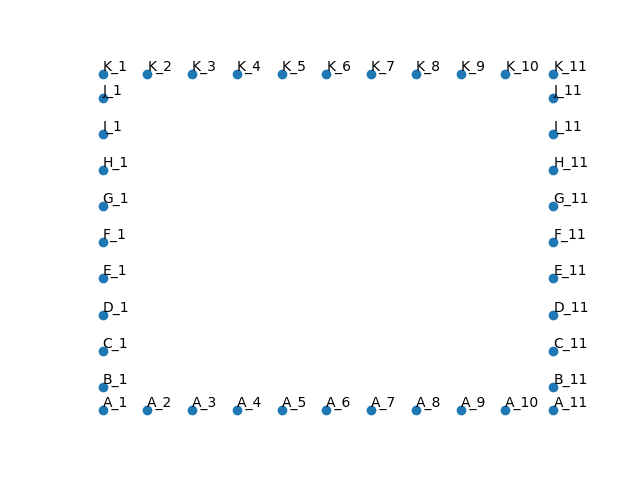

C:\Users\nmorand\AppData\Local\Temp\ipykernel_23744\4047990128.py:248: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = config[numero_cas]['distance']#


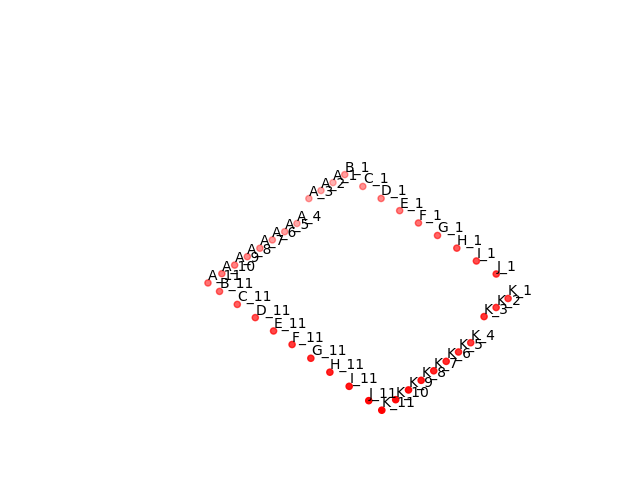

C:\Users\nmorand\AppData\Local\Temp\ipykernel_23744\4047990128.py:55: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = config[numero_cas]['distance']#


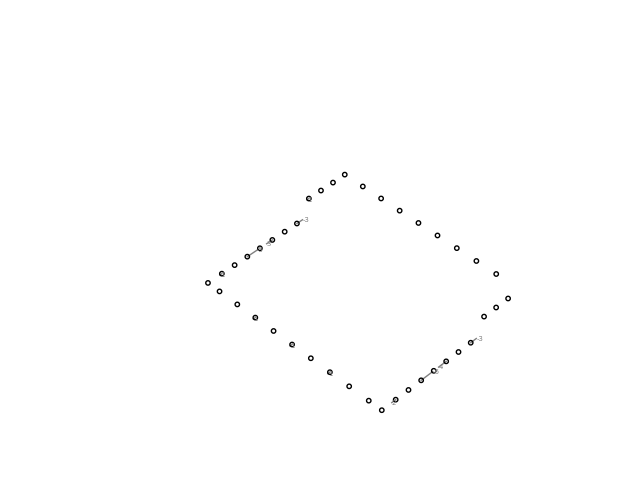

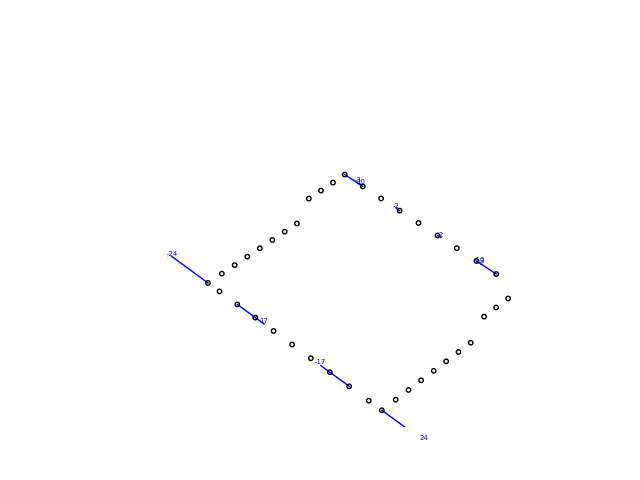

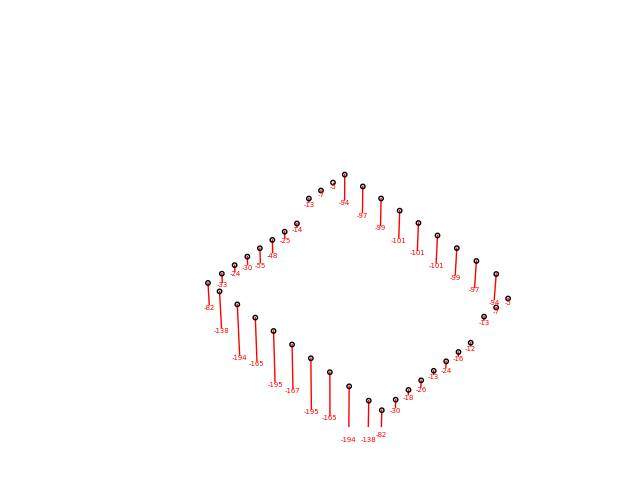

<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_1_RFx_kN.png
<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_1_RFy_kN.png
<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_1_RFz_kN.png
Cas 1 terminé
Cas 2 en début de traitement
Le Cas choisi est : {'nom': "Charges d'exploitation (Q)", 'composantes': ['2-Q'], 'type_combinaison': 'sum', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 45.0, 'elevation': 43.0, 'distance': 7.6, 'coef_RF': 0.4, 'valeur_mini_affichage_RFx_kN': 1.0, 'valeur_mini_affichage_RFy_kN': 1.0, 'valeur_mini_affichage_RFz_kN': 1.0}
Lmax 17888.0
min_scale_factor 91.86996045400852
Axe_min -9343.174978172667
Axe_max 44720.0
scale_factor_X=497.3033083124826, scale_factor_Y=417.8462975940201, scale_factor_Z=91.86996045400852


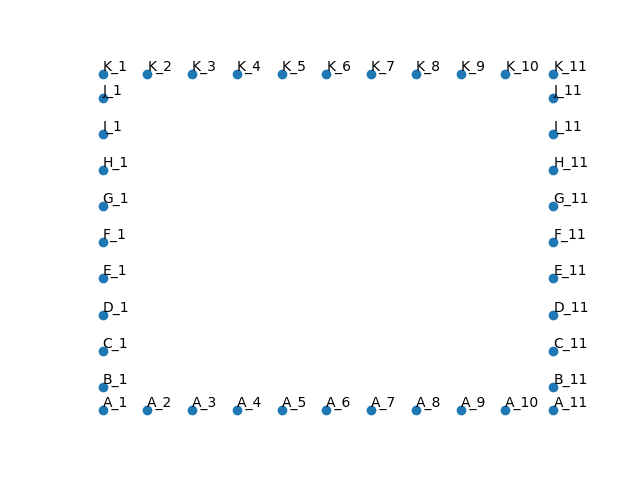

C:\Users\nmorand\AppData\Local\Temp\ipykernel_23744\4047990128.py:248: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = config[numero_cas]['distance']#


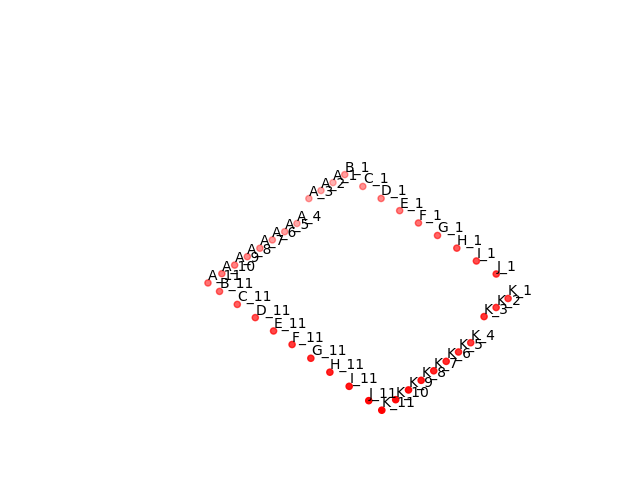

C:\Users\nmorand\AppData\Local\Temp\ipykernel_23744\4047990128.py:55: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = config[numero_cas]['distance']#


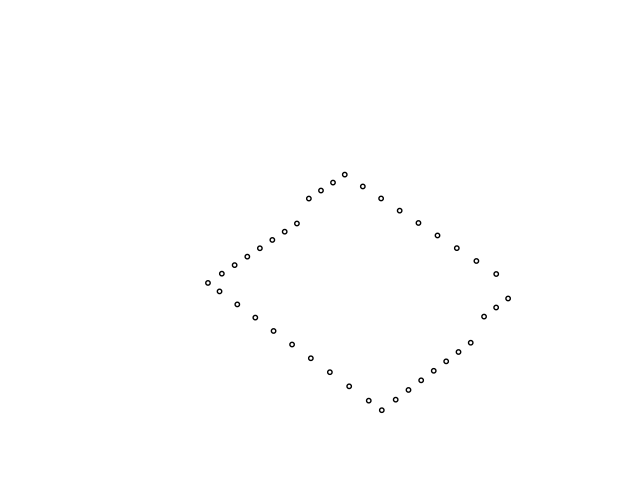

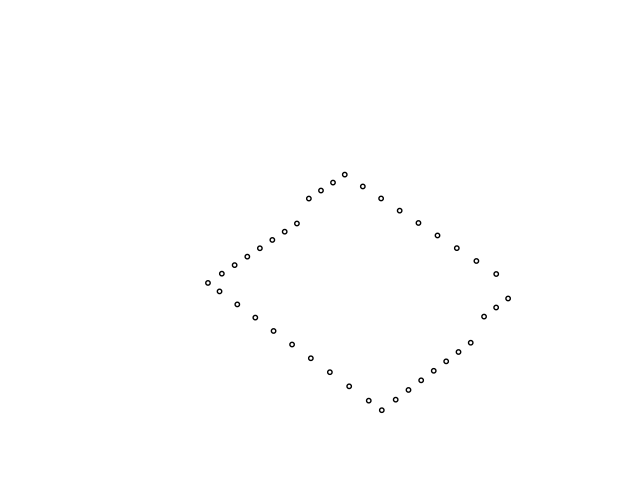

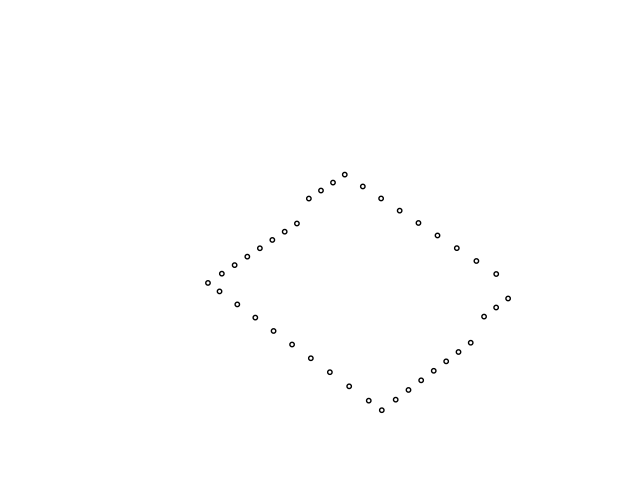

<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_2_RFx_kN.png
<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_2_RFy_kN.png
<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_2_RFz_kN.png
Cas 2 terminé
Cas 3 en début de traitement
Le Cas choisi est : {'nom': 'Neige (S)', 'composantes': ['3-S'], 'type_combinaison': 'sum', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 45.0, 'elevation': 43.0, 'distance': 7.6, 'coef_RF': 0.4, 'valeur_mini_affichage_RFx_kN': 1.0, 'valeur_mini_affichage_RFy_kN': 1.0, 'valeur_mini_affichage_RFz_kN': 1.0}
Lmax 17888.0
min_scale_factor 91.86996045400852
Axe_min -9343.174978172667
Axe_max 44720.0
scale_factor_X=497.3033083124826, scale_factor_Y=417.8462975940201, scale_factor_Z=91.86996045400852


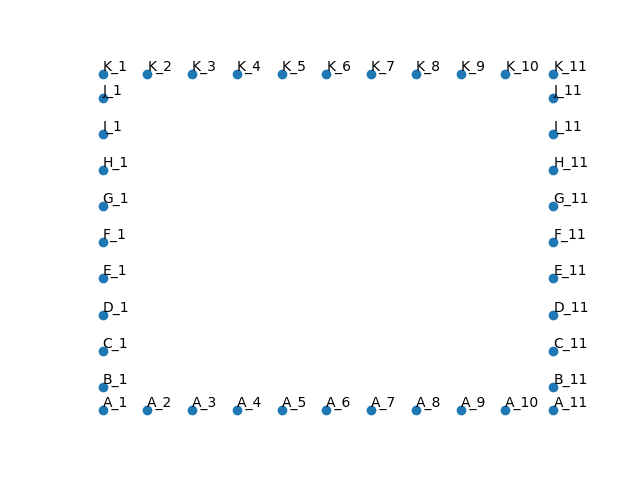

C:\Users\nmorand\AppData\Local\Temp\ipykernel_23744\4047990128.py:248: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = config[numero_cas]['distance']#


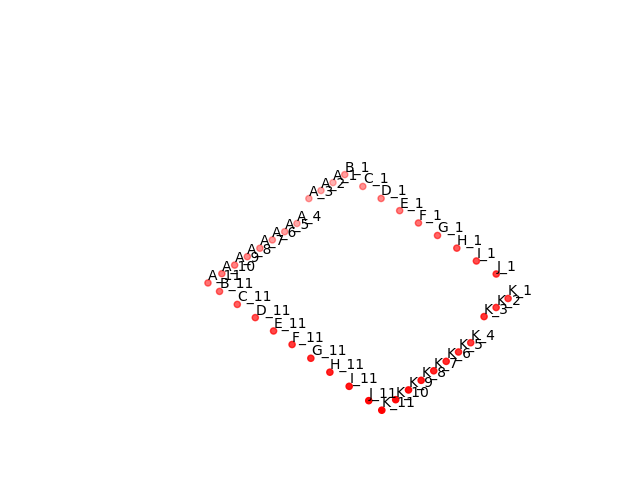

C:\Users\nmorand\AppData\Local\Temp\ipykernel_23744\4047990128.py:55: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = config[numero_cas]['distance']#


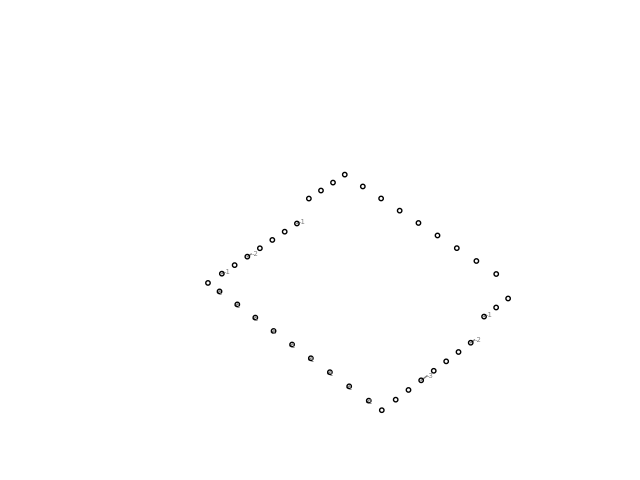

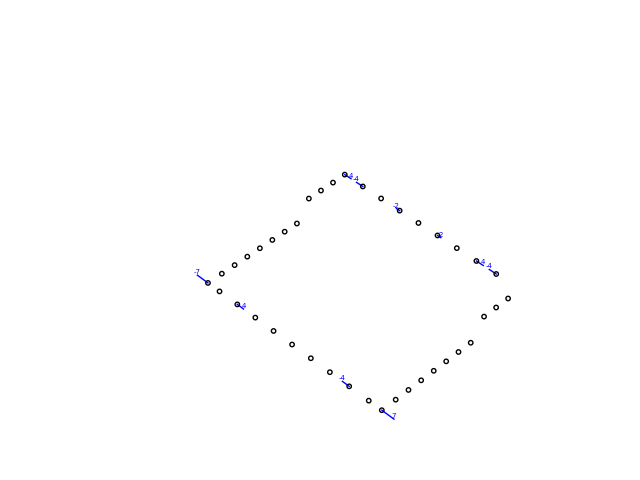

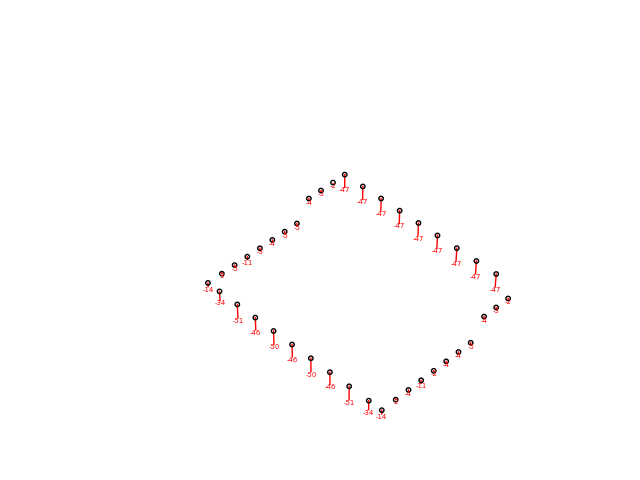

<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_3_RFx_kN.png
<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_3_RFy_kN.png
<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_3_RFz_kN.png
Cas 3 terminé
Cas 4 en début de traitement
Le Cas choisi est : {'nom': 'G+S', 'composantes': ['1-G', '3-S'], 'type_combinaison': 'sum', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 45.0, 'elevation': 43.0, 'distance': 7.6, 'coef_RF': 0.4, 'valeur_mini_affichage_RFx_kN': 1.0, 'valeur_mini_affichage_RFy_kN': 1.0, 'valeur_mini_affichage_RFz_kN': 1.0}
Lmax 17888.0
min_scale_factor 91.86996045400852
Axe_min -9343.174978172667
Axe_max 44720.0
scale_factor_X=497.3033083124826, scale_factor_Y=417.8462975940201, scale_factor_Z=91.86996045400852


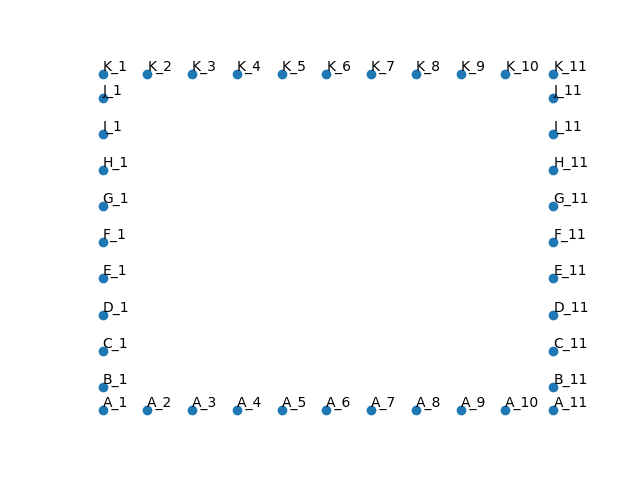

C:\Users\nmorand\AppData\Local\Temp\ipykernel_23744\4047990128.py:248: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = config[numero_cas]['distance']#


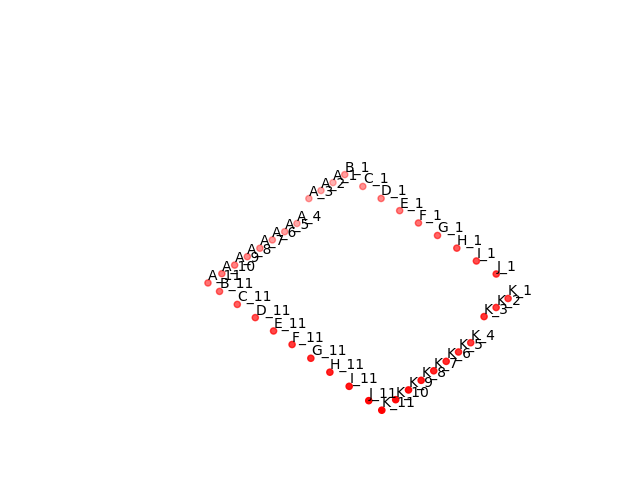

C:\Users\nmorand\AppData\Local\Temp\ipykernel_23744\4047990128.py:55: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = config[numero_cas]['distance']#


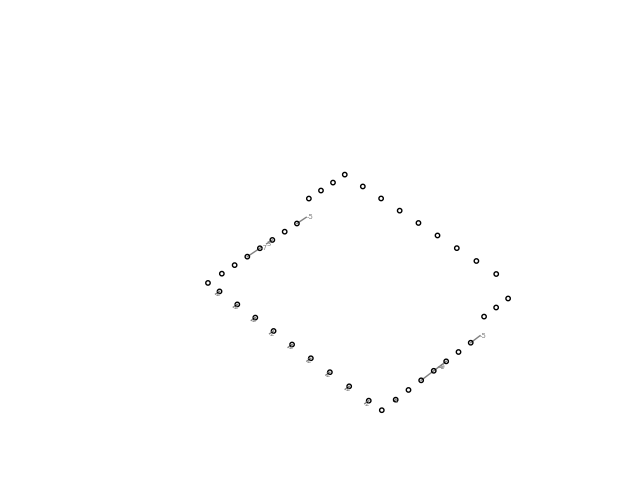

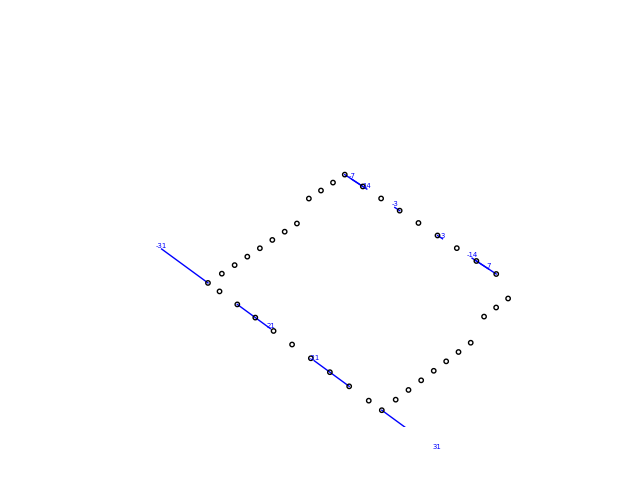

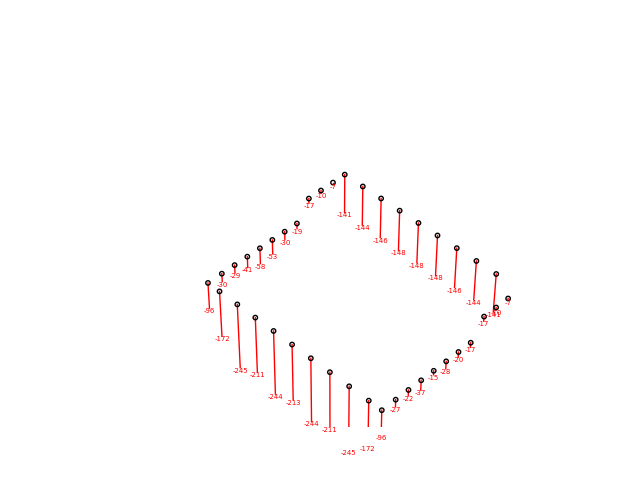

<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_4_RFx_kN.png
<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_4_RFy_kN.png
<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_4_RFz_kN.png
Cas 4 terminé
Cas 5 en début de traitement
Le Cas choisi est : {'nom': 'max(G,S)', 'composantes': ['1-G', '3-S'], 'type_combinaison': 'max', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 45.0, 'elevation': 43.0, 'distance': 7.6, 'coef_RF': 0.4, 'valeur_mini_affichage_RFx_kN': 1.0, 'valeur_mini_affichage_RFy_kN': 1.0, 'valeur_mini_affichage_RFz_kN': 1.0}
Lmax 17888.0
min_scale_factor 91.86996045400852
Axe_min -9343.174978172667
Axe_max 44720.0
scale_factor_X=497.3033083124826, scale_factor_Y=417.8462975940201, scale_factor_Z=91.86996045400852


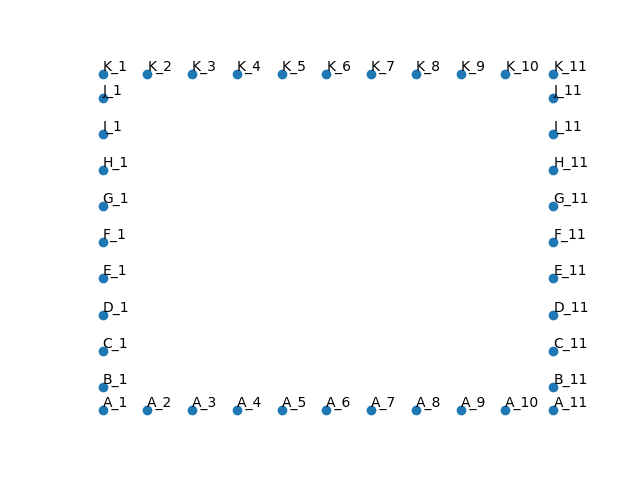

C:\Users\nmorand\AppData\Local\Temp\ipykernel_23744\4047990128.py:248: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = config[numero_cas]['distance']#


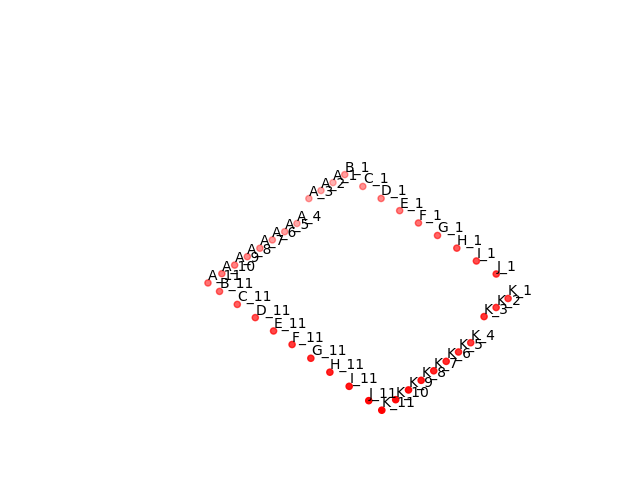

C:\Users\nmorand\AppData\Local\Temp\ipykernel_23744\4047990128.py:55: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = config[numero_cas]['distance']#


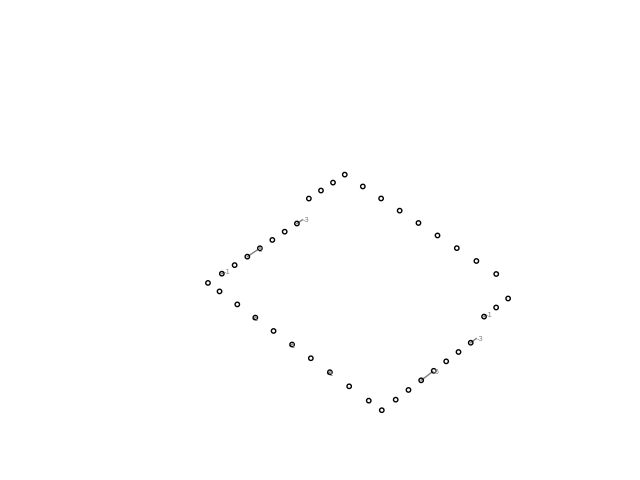

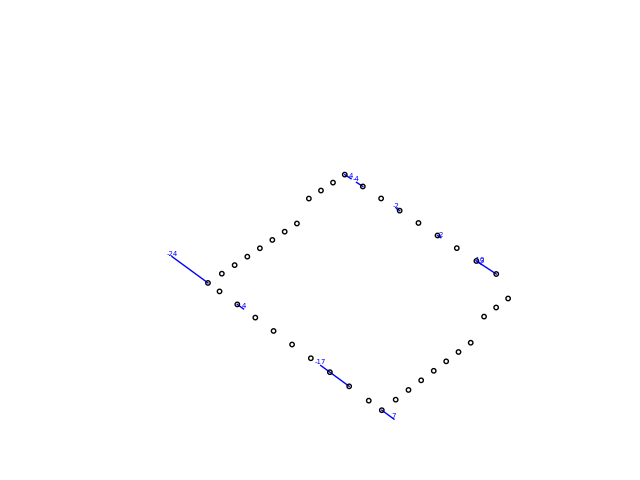

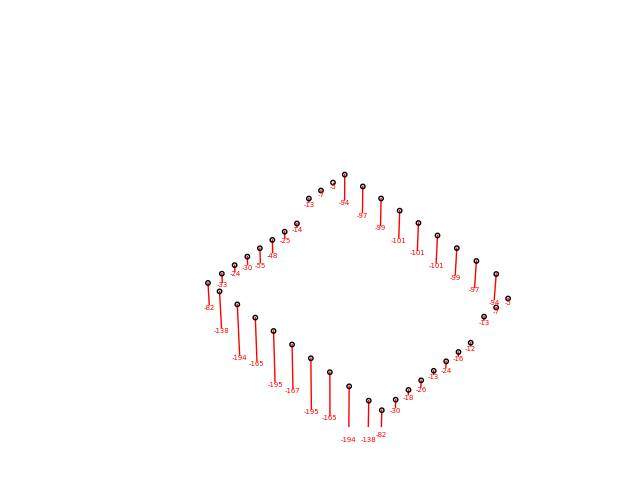

<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_5_RFx_kN.png
<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_5_RFy_kN.png
<class 'str'>
C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img\graph3D_charges_cas_5_RFz_kN.png
Cas 5 terminé
Traitement de Groupe 1 terminé


In [17]:
GROUPES = []
for id in groupe:
    print(f"Groupe {id} en début de traitement")
    GROUPES.append(Group(Groupe_id=id))
    GROUPES[id-1].load_coordonnees()
    GROUPES[id-1].load_ddc_individuelle()
    GROUPES[id-1].merge_points_charges_individuelles()
    # Liste des cas uniques de charges individuelles
    print(f'{GROUPES[id-1].df_ddc_individuelle_points.Cas.unique()}')
    for numero_cas in config.keys(): # Liste de cas
        print(f"Cas {numero_cas} en début de traitement")
        df_cas = GROUPES[id-1].sort_df(numero_cas=numero_cas)
        scale_factor, axe_min_max = GROUPES[id-1].calc_scale_factor(df=df_cas,
                                                                    coef=config[numero_cas]['coef_RF'])
        GROUPES[id-1].plot_graphes_reperage_points(numero_cas=numero_cas, axe_min_max=axe_min_max)
        create_3D_plot(df=df_cas, 
                    numero_cas=numero_cas, 
                    scale_factor=scale_factor,
                    axe_min_max=axe_min_max)
        # Select the 'DDC' sheet
        sheet = workbook.sheets['DdC(FRA)']
        fill_cas_in_excel(numero_cas=numero_cas, sheet=sheet, df=df_cas)
        print(f"Cas {numero_cas} terminé")
    print(f"Traitement de Groupe {id} terminé")

In [ ]:
GROUPES[0]

In [ ]:
GROUPES[0].df_ddc_individuelle_points[GROUPES[0].df_ddc_individuelle_points.Cas=='2-Q']

# Pour trouver la bonne orientation des graphes 3D

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import ipywidgets as widgets
from IPython.display import display
# import matplotlib.image as mpimg


# bg_img = mpimg.imread('input_data/image_structure.png') 

numero_cas = 1
# Plot 3D plot of the df_ddc_individuelle 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')

# # Display the background image
# # Plot a plane with the image
# x_bg = np.linspace(0, bg_img.shape[1], bg_img.shape[1])
# y_bg = np.linspace(0, bg_img.shape[0], bg_img.shape[0])
# x_bg, y_bg = np.meshgrid(x_bg, y_bg)
# ax.plot_surface(x_bg, y_bg, np.zeros_like(x_bg), rstride=1, cstride=1, facecolors=bg_img, shade=False)


ax.scatter(GR1.df_coordonnees['X'], GR1.df_coordonnees['Y'], GR1.df_coordonnees['Z'], c='r', marker='o')
#
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(axe_min_max[0],axe_min_max[1])
ax.set_ylim(axe_min_max[0],axe_min_max[1])
ax.set_zlim(axe_min_max[0],axe_min_max[1])
ax.set_axis_off()
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# Hide the axes

for i, txt in GR1.df_coordonnees.iterrows():
    ax.text(txt['X'], txt['Y'],txt['Z'], txt['Nom point'], ha='left', va='bottom')


# Define the update function for sliders
def update(elev, azim, dist):
    ax.view_init(elev=elev, azim=azim)
    ax.dist = dist
    fig.canvas.draw_idle()

# Create sliders
elev_slider = widgets.FloatSlider(value=config[numero_cas]['elevation'], min=0, max=90, step=1, description='Elevation:')
azim_slider = widgets.FloatSlider(value=config[numero_cas]['azimuth'], min=0, max=360, step=1, description='Azimuth:')
dist_slider = widgets.FloatSlider(value=config[numero_cas]['distance'], min=1, max=10, step=0.1, description='Distance:')

# Link sliders to update function
widgets.interactive(update, elev=elev_slider, azim=azim_slider, dist=dist_slider)

# Display the sliders
display(elev_slider, azim_slider, dist_slider)


In [ ]:
# Save the workbook (optional: save under a new name to avoid overwriting)
# workbook.save('TEMPLATE_DDC_with_image.xls')

# Close the workbook
# workbook.close()


# Creation du Cas .tex

In [ ]:
# create_latex_table(df = GR1.sort_df(numero_cas=1), 
#                     numero_cas=1)

In [114]:
# create_latex_cas(numero_cas=2)